## NeuroSynth

### Basic example with thresholded results

In [13]:
from neurolang.datalog.expressions import TranslateToLogic
from neurolang import expression_walker as ew
from neurolang.datalog.aggregation import DatalogWithAggregationMixin
from neurolang.datalog.chase import ChaseSemiNaive, ChaseNaive, ChaseNamedRelationalAlgebraMixin, ChaseGeneral
from neurolang.datalog.aggregation import Chase
from neurolang.expressions import ExpressionBlock, Symbol, Constant
from neurolang.logic import Implication
from neurolang.frontend.neurosynth_utils import NeuroSynthHandler
from neurolang.datalog import DatalogProgram
from neurolang.expression_walker import ExpressionBasicEvaluator
from neurolang.datalog.aggregation import AggregationApplication
from neurolang.regions import Region, region_union as region_union_
import typing 
from neurolang import frontend as fe
from nilearn import plotting

class DatalogTranslator(
    TranslateToLogic, ew.IdentityWalker, DatalogWithAggregationMixin
):
    pass

class Chase(
    Chase, ChaseNaive, ChaseNamedRelationalAlgebraMixin, ChaseGeneral
):
    pass

class Datalog(TranslateToLogic,
    DatalogWithAggregationMixin, DatalogProgram,
    ExpressionBasicEvaluator):
    pass

C_ = Constant
S_ = Symbol

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
y = S_('y')
z = S_('z')
over = S_('over')
neurosynth = S_('neurosynth')

nl = fe.NeurolangDL()
@nl.add_symbol
def region_union(
    region_set: typing.AbstractSet[Region]
) -> Region:
    return region_union_(region_set)

region_union = nl.symbols.region_union.expression()
region_union.args = (z,)

agap = AggregationApplication(region_union.functor, (y,))

In [7]:
q = 0.001
nshandler = NeuroSynthHandler()
neurosynth_data = nshandler.ns_region_set_from_term(
    'auditory',
    q=q
)

dl_ns = Datalog()
dl_ns.add_extensional_predicate_from_tuples(neurosynth, [('auditory', a) for a in neurosynth_data])

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:808: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(ke

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from

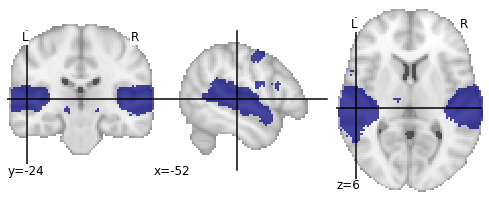

In [14]:
imps = tuple()
imps += (Implication(over(agap), neurosynth(C_('auditory'), y)),)

eb = ExpressionBlock(imps)
dl_ns.walk(eb)

dc = Chase(dl_ns)
solution_instance = dc.build_chase_solution()

list_regions = list(solution_instance['over'].value.unwrapped_iter())
for region in list_regions:
    plotting.plot_roi(region[0].spatial_image())

### Example with probabilistic results

In [1]:
import nibabel as nib
import neurosynth
import os

import pandas as pd
import neurolang.regions as nlr
import pickle

from nilearn import plotting
import numpy as np

from neurolang.expressions import Symbol, Constant, ExpressionBlock
from neurolang.datalog.expressions import Implication, Fact, Conjunction
from neurolang.probabilistic.expressions import ProbabilisticPredicate
from neurolang.probabilistic.probdatalog import ProbDatalogProgram

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/solver_datalog_naive.py:24: UserWarning: This module is being deprecated please use the datalog module
  warn("This module is being deprecated please use the datalog module")
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/expression_pattern_matching.py:87: UserWarning: Warning in class SolverNonRecursiveDatalogNaive overwrites ['fact', 'statement_intensional'] from base DatalogProgram[typing.Any]
  warn(warn_message)


In [2]:
prob_terms = pd.read_hdf('neurosynth_prob.h5', key='terms')
prob_voxels = pd.read_hdf('neurosynth_prob.h5', key='voxels')
prob_terms_voxels = pd.read_hdf('neurosynth_prob.h5', key='terms_voxels')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
auditory = prob_terms_voxels[prob_terms_voxels.index.get_level_values('term') == 'auditory']

In [4]:
file = open("xyz_from_neurosynth.pkl",'rb')
ret = pickle.load(file)
file.close()

In [5]:
regions = []
for index, row in auditory.iterrows():
    prob = row['prob']
    v_name = index[1]
    region = ret[v_name]
    regions.append((region, prob))

In [7]:
prob_img = nib.spatialimages.SpatialImage(
    np.zeros(regions[0][0].image_dim, dtype=float),
    affine=regions[0][0].affine
)

for r, p in regions:
    prob_img.dataobj[tuple(r.voxels.T)] = p

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:1239: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


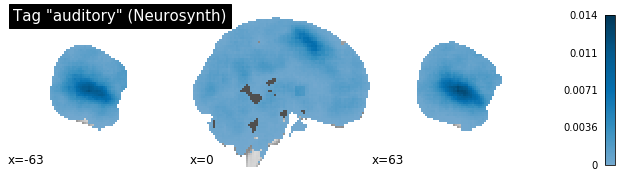

In [8]:
plotting.plot_stat_map(
    prob_img, title='Tag "auditory" (Neurosynth)', 
    cmap='PuBu',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 3),
)

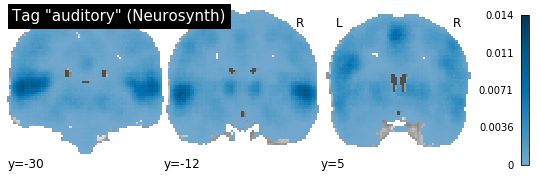

In [9]:
plotting.plot_stat_map(
    prob_img, title='Tag "auditory" (Neurosynth)', 
    cmap='PuBu',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 3),
)

In [10]:
prob = prob_img.get_data()
prob_mask = prob > 0
prob_mask_values = prob[prob_mask]

In [11]:
import numpy as np
from scipy import special
from scipy.stats import norm

def p_to_z(p, sign):
    p = p / 2  # convert to two-tailed
    # prevent underflow
    p[p < 1e-240] = 1e-240
    # Convert to z and assign tail
    z = np.abs(norm.ppf(p)) * sign
    # Set very large z's to max precision
    z[np.isinf(z)] = norm.ppf(1e-240) * -1
    return z

def one_way(data, n):
    """ One-way chi-square test of independence.
    Takes a 1D array as input and compares activation at each voxel to
    proportion expected under a uniform distribution throughout the array. Note
    that if you're testing activation with this, make sure that only valid
    voxels (e.g., in-mask gray matter voxels) are included in the array, or
    results won't make any sense!
    """
    term = data.astype('float64')
    no_term = n - term
    t_exp = np.mean(term, 0)
    t_exp = np.array([t_exp, ] * data.shape[0])
    nt_exp = n - t_exp
    t_mss = (term - t_exp) ** 2 / t_exp
    nt_mss = (no_term - nt_exp) ** 2 / nt_exp
    chi2 = t_mss + nt_mss
    return special.chdtrc(1, chi2)

res = one_way(np.round(prob_mask_values * 10000), 10000)

In [12]:
def fdr(p, q=.05):
    """ Determine FDR threshold given a p value array and desired false
    discovery rate q. """
    s = np.sort(p)
    nvox = p.shape[0]
    null = np.array(range(1, nvox + 1), dtype='float') * q / nvox
    below = np.where(s <= null)[0]
    return s[max(below)] if len(below) else -1

p_values_corrected = fdr(res, q=1e-25)

In [13]:
p_value_image = np.zeros_like(prob)
p_value_image[prob_mask] = -np.log10(res)

p_value_image = nib.spatialimages.SpatialImage(p_value_image, affine=prob_img.affine)
-np.log10(p_values_corrected)

27.793284044102236

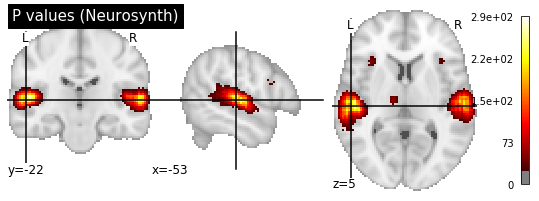

In [14]:
plotting.plot_stat_map(p_value_image, title='P values (Neurosynth)', threshold=-np.log10(p_values_corrected))

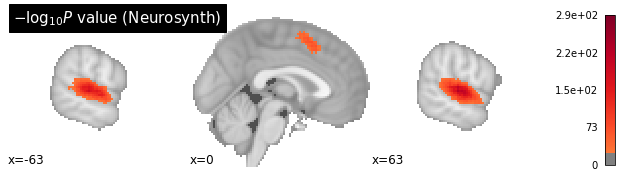

In [15]:
plotting.plot_stat_map(
    p_value_image, 
    title=r'$-\log_{10} P$ value (Neurosynth)', 
    threshold=-np.log10(p_values_corrected), 
    cmap='YlOrRd',
    display_mode='x',
    cut_coords=np.linspace(-63, 63, 3)
)

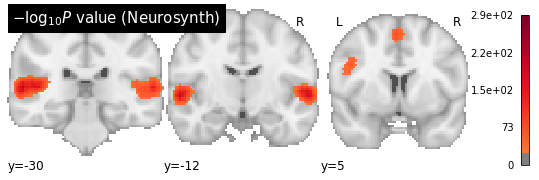

In [16]:
plotting.plot_stat_map(
    p_value_image, title=r'$-\log_{10} P$ value (Neurosynth)', threshold=-np.log10(p_values_corrected),
    cmap='YlOrRd',
    display_mode='y',
    cut_coords=np.linspace(-30, 5, 3)
)